In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pylab as plt
from skimage.io import imread

import numpy as np
from skimage.transform import rescale


def mse(ch1, ch2):
    return np.average((ch1 - ch2)**2)


def channel_crop(camera):
    height, width = camera.shape
    height //= 3

    cut = 0.15
    hcut, wcut = int(height * cut), int(width * cut)

    frames = []
    for i in range(3):
        hfrom, hto = height * i + hcut, height * (i + 1) - hcut
        wfrom, wto = wcut, width - wcut

        frame = camera[hfrom:hto, wfrom:wto]
        frames.insert(0, frame)

    return np.dstack(frames)


def channel_split(img):
    img=np.array(img, dtype=np.int64)
    img=img[:][0:img.shape[0]-img.shape[0]%3]
    return np.array_split(img,3)

def shift(img, offset):
    r, g, b = channel_split(img)
    height, width = r.shape

    i, j, k, h = offset

    r = np.roll(r, (i, j), axis=(1, 0))
    b = np.roll(b, (k, h), axis=(1, 0))

    hfrom, hto = max(j, h, 0), min(height, height + j, height + h)
    wfrom, wto = max(i, k, 0), min(width, width + i, width + k)

    return np.dstack([layer[hfrom:hto, wfrom:wto] for layer in [r, g, b]])


def channel_shift(ch1, ch2, offset):
    height, width = ch2.shape
    x, y = offset

    if x >= 0:
        if y >= 0:
            return ch1[y:, x:], ch2[:height-y, :width-x]
        else:
            return ch1[:height+y, x:], ch2[-y:, :width-x]
    else:
        if y >= 0:
            return ch1[y:, :width+x], ch2[:height-y, -x:]
        else:
            return ch1[:height+y, :width+x], ch2[-y:, -x:]


def channel_surface_search(ch1, ch2, metric, bounds):
    opt_offset = np.zeros(2, dtype=np.int64)

    min_metric = None
    for x_offset in range(*bounds):
        sch1, sch2 = channel_shift(ch1, ch2, (x_offset, 0))
        current_metric = metric(sch1, sch2)

        if min_metric is None or current_metric < min_metric:
            min_metric = current_metric
            opt_offset[0] = x_offset

    for y_offset in range(*bounds):
        sch1, sch2 = channel_shift(ch1, ch2, (opt_offset[0], y_offset))
        current_metric = metric(sch1, sch2)

        if current_metric < min_metric:
            min_metric = current_metric
            opt_offset[1] = y_offset

    return opt_offset


def channel_pyramid_search(ch1, ch2, metric, bounds, depth):
    offset = np.zeros(2, dtype=np.int64)
    for i in range(depth-1, -1, -2):
        sch1, sch2 = [rescale(ch, 0.5 ** i, mode='reflect') for ch in channel_shift(ch1, ch2, offset)]
        offset += (2**(2*i)) * channel_surface_search(sch1, sch2, metric, bounds)
        print(offset)
    return offset


def align(img, dest):
    """
    Aligns channels from image IMG and saves
    colored version as DEST image
    """
    camera = img
    camera_height, camera_width = camera.shape
    r, g, b = channel_split(img)

    n = 0
    while(4**n < camera_width):
      n+=1 
    depth = n-6
    red_offset = channel_pyramid_search(g, r, mse, (-25, 25), depth)
    blue_offset = channel_pyramid_search(g, b, mse, (-25, 25), depth)
    offset = np.concatenate((red_offset, blue_offset))
    r_coord = dest + red_offset
    r_coord[0] -= int(camera_height/3)
    b_coord = dest + blue_offset
    b_coord[0] += int(camera_height/3)
    new_img = shift(img, offset)

    print(r_coord, b_coord)
    return  np.array(new_img, dtype='uint8'), r_coord, b_coord

In [30]:
from numpy import genfromtxt

def link(path_img, path_csv):
  pic = imread(path_img)
  pix = np.array(pic)
  csv_data = genfromtxt(path_csv, delimiter=',')
  return pix, csv_data

path_img = '/content/gdrive/MyDrive/Colab Notebooks/Proscudin/public_tests/05_test_img_input/img.png'
path_csv='/content/gdrive/MyDrive/Colab Notebooks/Proscudin/public_tests/05_test_img_input/g_coord.csv'
img, g_coord = link(path_img, path_csv)

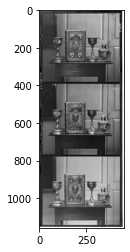

In [31]:
plt.imshow(img, cmap = 'gray', vmin=0, vmax=255)
plt.show()

In [32]:
new_img, r, b = align(img, g_coord)
print(r,b)

[108. 238.] [880. 238.]
[108. 238.] [880. 238.]


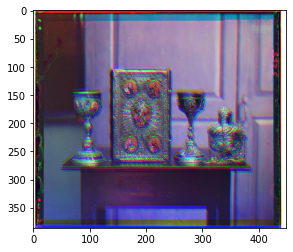

In [33]:
plt.subplot()
plt.imshow(new_img) 